## News Mood
### Objective
Create a Python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually. Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the
following news organizations: BBC, CBS, CNN, Fox, and New York times.

### Method
* Pull last 100 tweets from each outlet
* Perform a vader sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet
* Pull into a DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores
* Export the data in the DataFrame into a CSV file
* Save PNG images for each plot

### Analysis
* Because this only pulls the last 100 tweets from each news organization, it should only be considered a snapshot. To get a better idea of actual sentiment, many more tweets over a number of days would need to be pulled.


* In this particular snapshot, CBS was by far the most negative while BBC was negative but much closer to zero than the other news organizations.


* Except for CBS (again, in this particular snapshot), the news organizations' median compound sentiments are zero meaning they are balanced.


* The scatter plot for sentiment analysis for each tweet demonstrates that many are at zero (neutral).

In [1]:
#dependencies
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

In [2]:
#initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

#setup tweepy API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, parser=tweepy.parsers.JSONParser())

In [3]:
#make a function that adds to the df
def df_add(column, data):
    df.at[index, column] = data

In [4]:
#make a list containing the target news orgs
targets = ['@BBCNews', '@CBSNews', '@CNN', '@FoxNews', '@nytimes']

#set the index to 0
index = 0

#make an empty df
df = pd.DataFrame()

#loop through the targets list
for target in targets:
    
    #initialize variables
    counter = 0
    oldest_tweet = None
            
    #loop through 5 pages of tweets (100 total tweets)
    for page in range(5):

        #get all tweets from home feed
        public_tweets = api.user_timeline(target, max_id = oldest_tweet)

        #loop through all tweets 
        for tweet in public_tweets:

            #run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            
            #get the data and add to the df
            df_add('Media Sources', target)
            df_add('Date', tweet['created_at'])
            df_add('Tweet Text', tweet['text'])
            df_add('Tweet Polarity', results['compound'])
            df_add('Positive', results['pos'])
            df_add('Negative', results['neg'])
            df_add('Neutral', results['neu'])   
            df_add('Tweets Ago', counter)
           
            #increment counters 
            counter += 1            
            index += 1
            
            #get Tweet ID, subtract 1, assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

#change Tweets Ago to an int           
df['Tweets Ago'] = df['Tweets Ago'].astype(int)  

#export to a csv
df.to_csv('News_Mood.csv')

#show the head
df.head()

,Media Sources,Date,Tweet Text,Tweet Polarity,Positive,Negative,Neutral,Tweets Ago
0,@BBCNews,Sun Apr 08 15:51:58 +0000 2018,RT @BBC_HaveYourSay: Are you coming to Windsor...,0.0000,0.000,0.000,1.000,0
1,@BBCNews,Sun Apr 08 15:46:10 +0000 2018,Sunday Times' Rod Liddell 'mocks Wales' over S...,-0.4588,0.000,0.231,0.769,1
2,@BBCNews,Sun Apr 08 15:19:02 +0000 2018,Fishermen protest over lack of control of UK w...,-0.5106,0.000,0.323,0.677,2
3,@BBCNews,Sun Apr 08 14:36:51 +0000 2018,UK wife-carrying contest takes place in Dorkin...,0.0000,0.000,0.000,1.000,3
4,@BBCNews,Sun Apr 08 13:00:04 +0000 2018,RT @BBCSport: Day 4 - Commonwealth Games #GC20...,0.7003,0.254,0.000,0.746,4


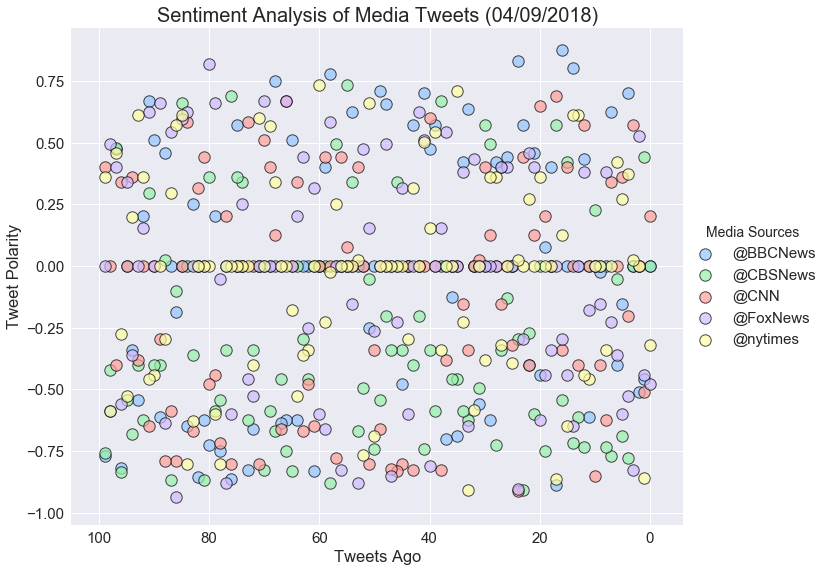

In [12]:
'''Sentiments Scatter Plot'''

#make the font scale larger
sns.set(font_scale=1.5)

#make the plot
scatter = sns.lmplot(x='Tweets Ago', y='Tweet Polarity', data=df, fit_reg=False, palette="pastel",
            scatter_kws={'s': 130, 'alpha':0.7, 'linewidths':1, 'edgecolor':'k'}, 
            legend_out=True, hue='Media Sources', size=8, aspect=1.25)

#get today's date
date_now = datetime.now()
today = date_now.strftime("%m/%d/%Y")

#set the title
plt.title(f"Sentiment Analysis of Media Tweets ({today})", fontsize=20)

#reverse the x axis
scatter.fig.axes[0].invert_xaxis()

#save as a png
scatter.savefig('Sentiments_Scatter_Plot.png')

#show the plot
plt.show()

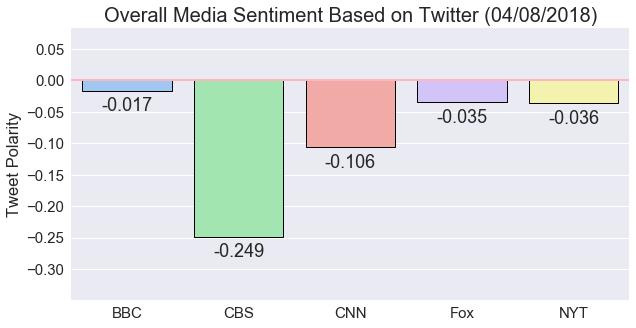

In [11]:
'''Overall Sentiments Barplot'''

#make the font scale larger
sns.set(font_scale=1.5)

#group by Media Sources and only include Tweet Poloarity
#get the aggregate compound sentiment
#reset the index so Media Sources is a regular column
polarity_agg = (df.groupby('Media Sources')['Tweet Polarity'].agg(np.mean)).reset_index()

#set the plot size
plt.figure(figsize=(10,5))

#make the bar plot
bars = sns.barplot(x='Media Sources', y='Tweet Polarity', data=polarity_agg, palette="pastel", 
                  ci=None, edgecolor='k', linewidth=1)

#make a line a y=0
bars.axhline(linewidth=2, color='lightpink')

#make the title
plt.title(f"Overall Media Sentiment Based on Twitter ({today})", fontsize=20)

#remove the x label and change the news names
plt.xlabel('')
bars.set(xticklabels=["BBC", "CBS", "CNN", "Fox", "NYT"])

#change the y axis 
plt.ylim(min(polarity_agg['Tweet Polarity'])-.1, max(polarity_agg['Tweet Polarity'])+.1)

#get the bar value numbers and put them on the bars
for index, row in polarity_agg.iterrows():
    bars.text(index, row['Tweet Polarity']-.01, '{:+}'.format(round(row['Tweet Polarity'], 3)), ha="center", va='top')

#save as a png
fig = bars.get_figure()
fig.savefig("Overall_Media_Sentiment.png")

#show the plot
plt.show()